# Load package

In [2]:
%cd ..

E:\Coding\Python\PlasmaChemistry


In [49]:
import os
import math
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

In [4]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import Layout
from IPython.display import display
import ipywidgets as widgets

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams["font.size"] = 17

In [6]:
from plasmistry.molecule import (H2_vib_group, CO_vib_group, CO2_vib_group)
from plasmistry.molecule import (H2_vib_energy_in_eV, H2_vib_energy_in_K,
                                 CO2_vib_energy_in_eV, CO2_vib_energy_in_K,
                                 CO_vib_energy_in_eV, CO_vib_energy_in_K)
from plasmistry.io import (LT_constructor, standard_Arr_constructor,
                           chemkin_Arr_2_rcnts_constructor,
                           chemkin_Arr_3_rcnts_constructor, eval_constructor,
                           reversed_reaction_constructor, alpha_constructor,
                           Cros_Reaction_block, Coef_Reaction_block)
from plasmistry.reactions import (CrosReactions, CoefReactions)
from plasmistry.electron import EEDF
from plasmistry.electron import get_maxwell_eedf

In [7]:
import yaml
yaml.add_constructor(u"!eval", eval_constructor)
yaml.add_constructor(u"!LT", LT_constructor)
yaml.add_constructor("!StandardArr", standard_Arr_constructor)
yaml.add_constructor("!ChemKinArr_2_rcnt", chemkin_Arr_2_rcnts_constructor)
yaml.add_constructor("!ChemKinArr_3_rcnt", chemkin_Arr_3_rcnts_constructor)
yaml.add_constructor("!rev", reversed_reaction_constructor)
yaml.add_constructor("!alpha", alpha_constructor)

In [8]:
_species_list = [
    'E', 'H2(v0-14)', 'CO2(v0-21)', 'CO(v0-10)', 'O2', 'H2O', 'H', 'O', 'OH'
]
_init_yaml_file_path = './_yaml/test_0.yaml'
_vari_dict = dict(H2_vib_energy_in_eV=H2_vib_energy_in_eV,
                  H2_vib_energy_in_K=H2_vib_energy_in_K,
                  CO2_vib_energy_in_eV=CO2_vib_energy_in_eV,
                  CO2_vib_energy_in_K=CO2_vib_energy_in_K)

# Set widgets functions
`yaml file` => `rctn_all` (dict inside)
            => `rctn_df` (dataframe insdie) 
            => `rctn_instances` (instances inside)
- `get_species_from_widgets`
- `load_reactions_from_widgets`
- `get_rctn_df_from_widgets`

In [19]:
# ---------------------------------------------------------------------------- #
#   Load rctn_all (dict inside) from yaml file.
# ---------------------------------------------------------------------------- #
def load_reactions_from_widgets():
    with open(_widgets['path'].value, 'r') as f:
        rctn_block = yaml.load(f)
    return rctn_block[-1]['The reactions considered']


# ---------------------------------------------------------------------------- #
#   Set rctn_df (dataframe insdie) from rctn_all (dict inside) and widgets.
#   rctn_all:
#       keys:
#             electron reactions
#             relaxation reactions
#             chemical reactions
#             decom_recom reactions
#   rctn_df
#       keys: species
#             electron
#             chemical
#             decom_recom
#             relaxation
# ---------------------------------------------------------------------------- #
rctn_df = {
    'species': None,
    'electron': None,
    'chemical': None,
    'decom_recom': None,
    'relaxation': None
}


def get_species_from_widgets(_event):
    print('Get species from widgets ...', end=' ')
    species = []
    for _ in _widgets['species'].value:
        if _ == 'H2(v0-14)':
            species.append('H2')
            species.extend([f'H2(v{v})' for v in range(1, 15)])
        elif _ == 'CO2(v0-21)':
            species.append('CO2')
            species.extend([f'CO2(v{v})' for v in range(1, 22)])
        elif _ == 'CO(v0-10)':
            species.append('CO')
            species.extend([f'CO(v{v})' for v in range(11)])
        else:
            species.append(_)
    rctn_df['species'] = pd.Series(species)
    print('DONE!')


def get_rctn_df_from_widgets(_):
    print('Get reaction dataframe from widgets ...', end=' ')
    rctn_df['electron'] = pd.DataFrame(
        columns=['formula', 'type', 'threshold_eV', 'cross_section'])
    rctn_df['chemical'] = pd.DataFrame(
        columns=['formula', 'type', 'reactant', 'product', 'kstr'])
    rctn_df['relaxation'] = pd.DataFrame(
        columns=['formula', 'type', 'reactant', 'product', 'kstr'])
    rctn_df['decom_recom'] = pd.DataFrame(
        columns=['formula', 'type', 'reactant', 'product', 'kstr'])
    # ------------------------------------------------------------------------ #
    #    rctn_df that is generated from the widgets and rctn_all.
    # ------------------------------------------------------------------------ #
    #   electron
    for _ in _widgets['electron'].value:
        _df = rctn_all['electron reactions'][_]
        _cros_block = Cros_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict)
        if _ == 'H2_ele_dis_via_b':
            factor = 1e-20
        else:
            factor = 1
        rctn_df['electron'] = pd.concat([
            rctn_df['electron'],
            _cros_block.generate_crostn_dataframe(factor=factor)
        ],
                                        ignore_index=True,
                                        sort=False)

    # ------------------------------------------------------------------------ #
    #   relaxation
    for _ in _widgets['relaxation'].value:
        _df = rctn_all['relaxation reactions'][_]
        _coef_block = Coef_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict)
        rctn_df['relaxation'] = pd.concat(
            [rctn_df['relaxation'],
             _coef_block.generate_crostn_dataframe()],
            ignore_index=True,
            sort=False)

    # ------------------------------------------------------------------------ #
    #   chemical
    for _ in _widgets['chemical'].value:
        _df = rctn_all['chemical reactions'][_]
        _coef_block = Coef_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict)
        rctn_df['chemical'] = pd.concat(
            [rctn_df['chemical'],
             _coef_block.generate_crostn_dataframe()],
            ignore_index=True,
            sort=False)

    # ------------------------------------------------------------------------ #
    #    decom_recom
    for _ in _widgets['decom_recom'].value:
        _df = rctn_all['decom_recom reactions'][_]
        _coef_block = Coef_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict)
        rctn_df['decom_recom'] = pd.concat(
            [rctn_df['decom_recom'],
             _coef_block.generate_crostn_dataframe()],
            ignore_index=True,
            sort=False)
    print('DONE!')


# ---------------------------------------------------------------------------- #
def rctn_all_dict_keys_to_formulas(_key):
    _formula = _key.replace('_to_', ' => ')
    _formula = _formula.replace('_', ' + ')
    return _formula


# ============================================================================ #
rctn_instances = {'cros reactions': None, 'coef reactions': None}


# ---------------------------------------------------------------------------- #
def from_rctn_df_to_cros_instance(_df):
    split_df = _df['formula'].str.split('\s*=>\s*', expand=True)
    reactant = split_df[0]
    product = split_df[1]
    return reactant, product


def from_rctn_df_to_coef_instance(_df):
    reactant = _df['reactant']
    product = _df['product']
    kstr = _df['kstr']
    return reactant, product, kstr


# ---------------------------------------------------------------------------- #
def instance_dataframe(_):
    print("Get instance from rctn_df ...", end=' ')
    # ------------------------------------------------------------------------ #
    reactant, product = from_rctn_df_to_cros_instance(rctn_df['electron'])

    rctn_instances['cros reactions'] = CrosReactions(
        species=rctn_df['species'],
        reactant=reactant,
        product=product,
        k_str=None)
    # ------------------------------------------------------------------------ #
    reactant, product, kstr = pd.Series(), pd.Series(), pd.Series()
    for _key in ['relaxation', 'chemical', 'decom_recom']:
        _r, _p, _k = from_rctn_df_to_coef_instance(rctn_df[_key])
        reactant = pd.concat([reactant, _r])
        product = pd.concat([product, _p])
        kstr = pd.concat([kstr, _k])

    rctn_instances['coef reactions'] = CoefReactions(
        species=rctn_df['species'],
        reactant=reactant,
        product=product,
        k_str=kstr)
    rctn_instances['coef reactions'].compile_k_str()
    # ------------------------------------------------------------------------ #
    print('DONE!')

In [20]:
# ---------------------------------------------------------------------------- #
#   _widgets
#       path
#
_widgets = dict()
# ---------------------------------------------------------------------------- #
_widgets['path'] = widgets.Text(value=_init_yaml_file_path)
display(widgets.HBox([widgets.HTML('<b>Yaml File Path</b>'),
                      _widgets['path']]))
rctn_all = load_reactions_from_widgets()
# ---------------------------------------------------------------------------- #
#   Set SelectMultiple widgets
#       ele, eletron reactions
#       rel, relaxation reactions
#       che, chemical reactions
#       recom, recombination reactions and
# ---------------------------------------------------------------------------- #
for _, _option, _height in [
    ('species', _species_list, '400px'),
    ('electron', rctn_all['electron reactions'].keys(), '150px'),
    ('relaxation', rctn_all['relaxation reactions'].keys(), '150px'),
    ('chemical', rctn_all['chemical reactions'].keys(), '400px'),
    ('decom_recom', rctn_all['decom_recom reactions'].keys(), '400px')
]:
    if _ in ('chemical', 'decom_recom'):
        show_option = [(rctn_all_dict_keys_to_formulas(_o), _o)
                       for _o in _option]
    else:
        show_option = _option
    _widgets[_] = widgets.SelectMultiple(options=show_option,
                                         value=list(_option),
                                         layout=Layout(height=_height))

# ---------------------------------------------------------------------------- #
#   Set FloatText widgets
# ---------------------------------------------------------------------------- #
for _, _value in [('electron_density', 1.0), ('Te', 1.0), ('CO2_density', 1.0),
                  ('CO2_Tvib', 1000), ('H2_density', 1.0), ('H2_Tvib', 1000),
                  ('CO_density', 1.0), ('CO_Tvib', 1000)]:
    _widgets[_] = widgets.FloatText(value=_value, layout=Layout(width='100px'))
# ---------------------------------------------------------------------------- #
#   Set Buttons
# ---------------------------------------------------------------------------- #
_button = dict()
_button['load reactions'] = widgets.Button(description='rctn_all => rctn_df')
_button['instance rctn_df'] = widgets.Button(description='=> rctn_instances')


# ---------------------------------------------------------------------------- #
#   Display widgets
# ---------------------------------------------------------------------------- #
def _label(_str):
    return widgets.HTML(f'<b>{_str}</b>')


display(
    widgets.HBox([
        #1
        widgets.VBox([_label('SPECIES'), _widgets['species']]),
        #2
        widgets.VBox([
            _label('ELECTRON REACTIONS'), _widgets['electron'],
            _label('RELAXATION REACTIONS'), _widgets['relaxation']
        ]),
        #3
        widgets.VBox([_label('CHEMICAL REACTIONS'), _widgets['chemical']]),
        #4
        widgets.VBox(
            [_label('DECOM_RECOM REACTIONS'), _widgets['decom_recom']])
    ]))
display(
    widgets.GridBox([
        widgets.HTML('<b>electron density</b>'), _widgets['electron_density'],
        widgets.HTML('<b>Te_eV</b>'), _widgets['Te'],
        widgets.HTML('<b>CO2_density</b>'), _widgets['CO2_density'],
        widgets.HTML('<b>CO2_Tvib</b>'), _widgets['CO2_Tvib'],
        widgets.HTML('<b>H2_density</b>'), _widgets['H2_density'],
        widgets.HTML('<b>H2_Tvib'), _widgets['H2_Tvib']
    ],
                    layout=widgets.Layout(
                        grid_template_columns="repeat(4, 20%)")))
display(widgets.HBox([_button['load reactions'], _button['instance rctn_df']]))
# ---------------------------------------------------------------------------- #
#   Widgets events
# ---------------------------------------------------------------------------- #
_button['load reactions'].on_click(get_rctn_df_from_widgets)
_button['load reactions'].on_click(get_species_from_widgets)
_button['instance rctn_df'].on_click(instance_dataframe)

GridBox(children=(HTML(value='<b>electron density</b>'), FloatText(value=1.0, layout=Layout(width='100px')), H…

Get reaction dataframe from widgets ... DONE!
Get species from widgets ... DONE!
Get instance from rctn_df ... DONE!


In [21]:
eedf = EEDF(max_energy_eV=30, grid_number=300)
electron_energy_grid = eedf.energy_point
eedf.set_density_per_J(get_maxwell_eedf(eedf.energy_point, Te_eV=1.0))

In [23]:
rctn_instances['cros reactions'].set_rate_const_matrix(
    crostn_dataframe=rctn_df['electron'],
    electron_energy_grid=electron_energy_grid)

# Start evolution

In [25]:
H2_percent_seq = [
    1, 0.93333, 0.88889, 0.83333, 0.77778, 0.66667, 0.5, 0.33333, 0.23077,
    0.16667, 0.13043, 0.09091, 0.07407, 0.0566, 0.03, 0.01, 0
]
time_end_seq = [
    0.38564, 0.46339, 0.58923, 0.66704, 0.69614, 0.8726, 0.97919, 1.01216,
    1.05427, 1.14294, 1.06026, 1.11772, 1.13853, 1.17361, 1.26435, 1.30063,
    1.27632
]
#### ====================
i_index = 0
H2_percent = H2_percent_seq[i_index]
time_end = time_end_seq[i_index] * 1e-3
#### =========================
y0 = rctn_instances['cros reactions'].get_initial_density(density_dict={
    'CO2':
    2.4e24 * (1 - H2_percent),
    'H2':
    2.4e24 * H2_percent,
    'E':
    1e19
},
                                                          min_density=1e1)

normalized_eedf = get_maxwell_eedf(eedf.energy_point, Te_eV=3.0)


def dndt_cros(t, y):
    _instance = rctn_instances['cros reactions']
    _instance.set_rate_const(eedf_normalized=normalized_eedf)
    _instance.set_rate(density=y)
    return _instance.get_dn()


def dndt_coef(t, y):
    _instance = rctn_instances['coef reactions']
    _instance.set_rate_const(Tgas_K=3500, EN_Td=1.0, Te_eV=3.0)
    _instance.set_rate(density=y)
    return _instance.get_dn()


def dndt_all(t, y):
    print(f"t = {t:.1e} s")
    return dndt_cros(t, y) + dndt_coef(t, y)

In [26]:
time_span = (0, time_end)
sol = solve_ivp(dndt_all, time_span, y0, method='BDF', rtol=5e-2)

t = 0.0e+00 s
t = 3.6e-31 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 0.0e+00 s
t = 3.6e-29 s
t = 3.6e-29 s
t = 7.3e-29 s
t = 7.3e-29 s
t = 4.4e-28 s
t = 4.4e-28 s
t = 8.0e-28 s
t = 8.0e-28 s
t = 4.4e-27 s
t = 4.4e-27 s
t = 8.1e-27 s
t = 8.

t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.4e-06 s
t = 2.7e-06 s
t = 2.7e-06 s
t = 2.7e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.6e-06 s
t = 2.

# Plot results

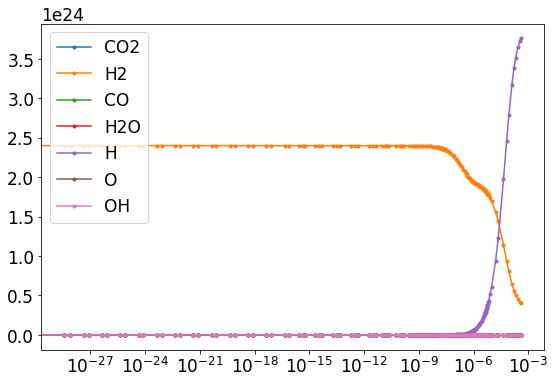

In [28]:
densities = dict()
for _ in ['CO2', 'H2', 'CO', 'H2O', 'H', 'O', 'OH']:
    densities[_] = sol.y[rctn_instances['cros reactions'].species ==
                         _].transpose()
    plt.semilogx(sol.t, densities[_], marker='.', label=_)
plt.legend()

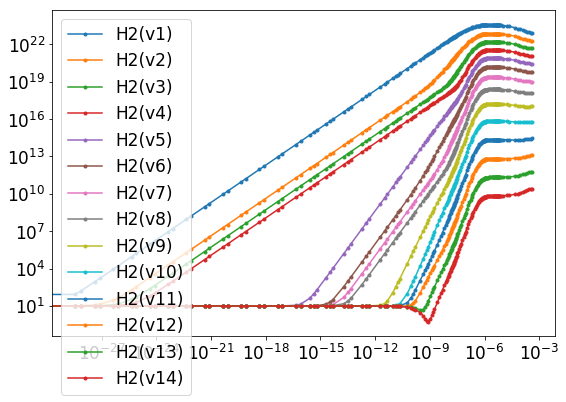

In [30]:
plt.figure()
for _ in rctn_instances['coef reactions'].species:
    if _.startswith('H2('):
        densities[_] = sol.y[rctn_instances['cros reactions'].species ==
                             _].transpose()
        plt.loglog(sol.t, densities[_], marker='.', label=_)
plt.legend()

## reaction info

In [33]:
sol.t.shape

(163,)

In [51]:
# _widgets['plot_vdf'] = widgets.FloatLogSlider(value=sol.t[1], min=sol.t[1], max=sol.t[-1],step=1)
_widgets['plot_vdf'] = widgets.FloatLogSlider(value=math.log10(sol.t[1]),
                                              min=math.log10(sol.t[1]),
                                              max=math.log10(sol.t[-1]))
display(_widgets['plot_vdf'])
_df_show_vdf = pd.Series(index=rctn_instances['cros reactions'].species)
_CO2_group = ['CO2'] + [f"CO2(v{_})" for _ in range(1, 22)]
_interp_result = interp1d(sol.t, sol.y)
def plot_CO2_vdf():
    _y_interp = _interp_result(_widgets['plot_vdf'].value)
    _df_show_vdf.value = _y_interp
    print(_df_show_vdf[_CO2_group])
_widgets['plot_vdf'].on_trait_change(lambda : #TODO))

FloatLogSlider(value=3.646840158522966e-29, max=-3.4138179258109274, min=-28.43808327145253)

C:\Users\PhyMan\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
  del sys.path[0]


3.646840158522966e-29
4.5911343322724887e-29
4.5911343322724887e-29
4.5911343322724887e-29
9.160517316143122e-29
9.160517316143122e-29
9.160517316143122e-29
2.8968099264424996e-28
2.8968099264424996e-28
2.8968099264424996e-28
5.779895679858501e-28
5.779895679858501e-28
5.779895679858501e-28
1.8277634986520265e-27
1.8277634986520265e-27
1.8277634986520265e-27
2.3010179152028576e-27
2.3010179152028576e-27
2.3010179152028576e-27
3.646867629536067e-27
3.646867629536067e-27
3.646867629536067e-27
4.591134332272489e-27
4.591134332272489e-27
4.591134332272489e-27
1.451844153377736e-26
1.451844153377736e-26
1.451844153377736e-26
4.591134332272489e-26
4.591134332272489e-26
4.591134332272489e-26
1.1532408034473118e-25
1.1532408034473118e-25
1.1532408034473118e-25
2.301017915202858e-25
2.301017915202858e-25
2.301017915202858e-25
4.5911343322724885e-24
4.5911343322724885e-24
4.5911343322724885e-24
2.3010179152028577e-23
2.3010179152028577e-23
2.3010179152028577e-23
2.3010179152028577e-22
2.30101791

In [52]:
_widgets['plot_vdf'].value = 2e-6

2e-06


In [31]:
rctn_instances['coef reactions'].set_rate(density=sol.y[:, -1])
rctn_instances['coef reactions'].view_rate_const_and_rate()

KeyError: 'relaxation reactions'

In [41]:
rctn_instances['electron reactions'].set_rate(density=sol.y[:, -1])
rctn_instances['electron reactions'].view_rate_const_and_rate().sort_values(
    by='rate_const', ascending=False)

,formula,rate_const,rate
99,E + H2(v14) => E + H2(v13),2.217809e-13,1.268596e+25
49,E + H2(v13) => E + H2(v14),2.127670e-13,1.456116e+25
95,E + H2(v13) => E + H2(v12),1.795071e-13,1.228495e+25
47,E + H2(v12) => E + H2(v13),1.704926e-13,1.478445e+25
91,E + H2(v12) => E + H2(v11),1.431449e-13,1.241296e+25
44,E + H2(v11) => E + H2(v12),1.345994e-13,1.584948e+25
87,E + H2(v11) => E + H2(v10),1.122962e-13,1.322321e+25
40,E + H2(v10) => E + H2(v11),1.045386e-13,1.801395e+25
83,E + H2(v10) => E + H2(v9),8.654299e-14,1.491296e+25
36,E + H2(v9) => E + H2(v10),7.975936e-14,2.176458e+25


## Species info

In [42]:
rctn_instances['electron reactions'].view_density(sol.y[:, -1]).sort_values(
    by='density', ascending=False)

,density,ratio
H,4.598193e+24,97.9%
H2,6.715575e+22,1.4%
H2(v1),2.200081e+22,0.5%
H2(v2),7.371029e+21,0.2%
H2(v3),2.598496e+21,0.1%
H2(v4),9.823688e+20,0.0%
H2(v5),4.023511e+20,0.0%
H2(v6),1.797933e+20,0.0%
H2(v7),8.788175e+19,0.0%
H2(v8),4.692038e+19,0.0%


In [43]:
print(f"H2 percent: {H2_percent}")
print(f"time end:{time_end}")
# print(f"O:  {rctn_instances['electron reactions'].view_density(sol.y[:,-1]).loc['O', 'density']:.2e}")
# print(f"H:  {rctn_instances['electron reactions'].view_density(sol.y[:,-1]).loc['H', 'density']:.2e}")
# print(f"OH: {rctn_instances['electron reactions'].view_density(sol.y[:,-1]).loc['OH', 'density']:.2e}")
##########
# max density
print('H  O  OH  CO Tvib(CO2) Tvib(H2)')
print(f"{sol.y[rctn_instances['electron reactions'].species=='H'].max(): .2e}",
      end=' ')
print(f"{sol.y[rctn_instances['electron reactions'].species=='O'].max(): .2e}",
      end=' ')
print(f"{sol.y[rctn_instances['electron reactions'].species=='OH'].max():.2e}",
      end=' ')
_df = rctn_instances['electron reactions'].view_density(sol.y[:, -1])
Tv_CO2 = -3380 / np.log(
    _df.loc['CO2(v1)', 'density'] / _df.loc['CO2', 'density'])
Tv_H2 = -5983 / np.log(_df.loc['H2(v1)', 'density'] / _df.loc['H2', 'density'])
print(f"{Tv_CO2:.0f}", end=' ')
print(f"{Tv_H2:.0f}", end=' ')

H2 percent: 1
time end:0.00038564
H  O  OH  CO Tvib(CO2) Tvib(H2)
 4.60e+24  6.52e+01 1.00e+01 7186 5361 

In [44]:
sol.y[rctn_instances['electron reactions'].species == 'H'].max()

4.598192728953616e+24

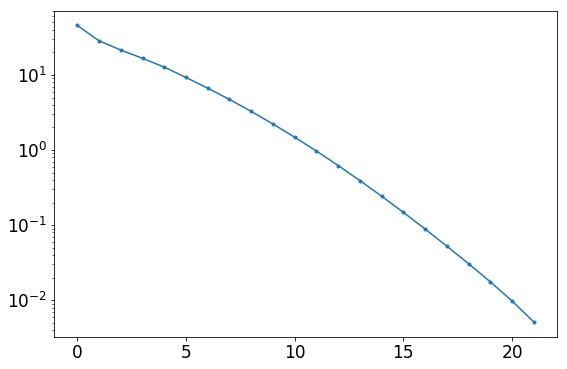

In [45]:
# plot CO2 vdf

x = ['CO2'] + [f'CO2(v{v})' for v in range(1, 22)]
y = [_df.loc[_, 'density'] for _ in x]
plt.semilogy(range(22), y, marker='.')

In [46]:
Tv_CO2 = -3380 / np.log(
    _df.loc['CO2(v1)', 'density'] / _df.loc['CO2', 'density'])
Tv_H2 = -5983 / np.log(_df.loc['H2(v1)', 'density'] / _df.loc['H2', 'density'])
print(f"Tvib(CO2): {Tv_CO2:.0f} K")
print(f"Tvib(H2): {Tv_H2:.0f} K")

Tvib(CO2): 7186 K
Tvib(H2): 5361 K
